<a href="https://www.kaggle.com/code/abrachan/sartorius-unet-from-scratch-with-pytorch?scriptVersionId=126859997" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

This notebook is a merging from the quoted notebook listed below based on my personal studying and digesting. Thanks a lot to these kindly contributors since their contributions really help me a lot!

* **<a href="https://www.kaggle.com/code/shnakazawa/semantic-segmentation-with-pytorch-and-u-net/notebook" style="text-decoration:none">Semantic Segmentation with PyTorch and U-Net</a>** (mainly)
* <a href="https://www.kaggle.com/code/frozenwolf/sartorius-visualization-training-u-net" style="text-decoration:none">🦠 Sartorius : Visualization + Training U-Net</a>
* 
* <a href="https://www.kaggle.com/code/nikmarker/sartorius-starter-torch-mask-r-cnn-lb-0-273" style="text-decoration:none">Sartorius - Starter Torch Mask R-CNN [LB=0.273]</a>
* <a href="https://www.kaggle.com/code/frozenwolf/sartorius-visualization-training-maskr-cnn" style="text-decoration:none">🧬 Sartorius : Visualization + Training MaskR-CNN</a>

And of course, as a noice in Kaggle, I will refernce most of the codes from the notebook above, rearrange and display them on my own way and style.


<br>
Read more about the UNet paper <a href="https://arxiv.org/abs/1505.04597" style="text-decoration:none">here</a>.

<br>

# **Import Libraries**

In [1]:
import os
import gc
import time
import random
import collections
from pathlib import Path
from tqdm.notebook import tqdm

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from albumentations import HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


import warnings
warnings.filterwarnings("ignore")

In [2]:
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA avaliable: {torch.cuda.is_available()}')

PyTorch version: 1.13.0
CUDA avaliable: True


<br>

# **Fix Randomness**

In [3]:
# Fix randomness

def fix_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = True
    
    os.environ['PYTHONHASHSEED'] = str(seed)


# Set seed
fix_all_seeds(2023)

# **Configurations**

In [4]:
# Directory setting
DATA_DIR = '/kaggle/input/sartorius-cell-instance-segmentation/'

TRAIN_CSV = DATA_DIR + 'train.csv'
TRAIN_PATH = DATA_DIR + 'train/'
TEST_PATH = DATA_DIR + 'test/'

MODEL_DIR = '/kaggle/working/'

FOLDS = 3                # Kfold cross-validation, here using a low value of 3 just for demonstration.
NUM_WORKERS = 0          # 2
THRESHOLD_MASK = 0.5     # Threshold for mask prediction
BATCH_SIZE = 20
EPOCHS = 8               # here using a low value of 8 just for demonstration.

USE_SCHEDULER = False  # Use a StepLR scheduler if True. Not tried yet.
MOMENTUM = 0.9
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001

## Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {DEVICE} device')

Using cuda device


In [5]:
torch.cuda.get_device_properties(DEVICE)

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

<br>

# **Helper Functions**

## rle_decode()

Decode the RLE (annotation) of an particular cell instance in an image to its correspongding mask.

In [6]:
def rle_decode(rle, img_shape, color=1):
    """Decode the RLE (annotation) of an particular cell instance in an image to its correspongding mask.

    Args:
        rle (str): mask with run length encoding.
        img_shape ((int, int)): (height, width) of the image, also the shape of mask np.ndarray to return.
        color (int): brightness of the mask pixel. Default to 1.

    Returns:
        np.ndarray: 1 - mask, 0 - background.
    """
    rle_list = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_list[0:][::2], rle_list[1:][::2])]
    starts -= 1
    ends = starts + lengths
    
    mask = np.zeros(img_shape[0] * img_shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = color
    
    return mask.reshape(img_shape)

## rle_encode()

In [7]:
def rle_encode(predicted_img):
    predicted_img = (predicted_img > THRESHOLD_MASK).astype(int)
    height, width = predicted_img.shape
    
    # Get the index of the masked pixel
    pixels = predicted_img.copy()
    pixels_list = []
    for y in range(height):
        for x in range(width):
            if pixels[y][x] != 0:
                pixels_list.append(y * width + x)
    
    
    # RLE encoding
    rle_list = []
    start = pixels_list[0]
    count = 1
    for i in range(1, len(pixels_list)):
        if pixels_list[i] == pixels_list[i-1] + 1:
            count += 1
        else:
            rle_list.extend([start, count])
            start = pixels_list[i]
            count = 1
    rle_list.extend([start, count])
    
    rle_str = [str(x) for x in rle_list]
    
    return ' '.join(rle_str)

<br>

## build_image_mask

Decode RLEs (annotations) of all cell instance in an image into one mask image.

In [8]:
def build_image_mask(img, rle_list):
    """Decode RLEs (annotations) of all cell instance in an image into one mask image.
    
    Args:
        img (np.ndarray): image with single channel or multiple channels.
        rle_list (list of str): rles of all cell instances in an image as a list.
    
    Returns:
        np.ndarray: 1 - mask, 0 - background.
    """
    img_shape = img.shape
    h = img_shape[0]
    w = img_shape[1]
    
    mask = np.zeros((h, w))
    for rle in rle_list:
        mask += rle_decode(rle, (h, w))
    mask = mask.clip(0,1)
    
    return mask

<br>

## transforms()

For segmentation tasks, the segmentation masks also need to undergo transformations and augmentations.

Please also see <a href="https://albumentations.ai/docs/getting_started/mask_augmentation/" style="text-decoration:none">Albumentations Documentation/Mask augmentation for segmentation</a>. In this notebook, transforms are applied in the `CellDataset()` class.

In [9]:
def transforms(train_only=True):
    """converts the image, a PIL image, into a PyTorch Tensor"""
    
    transforms = [A.Resize(256, 256, p=1)]
    
    if train_only:
        ## during training, randomly flip the training images and ground-truth for data augmentation
        transforms.append(A.HorizontalFlip(p=0.5))
        transforms.append(A.VerticalFlip(p=0.5))
        transforms.append(A.Transpose(p=0.5))
    else:
        ## for validation phase and test phase
        pass
    
    transforms.append(ToTensorV2())
    
    return A.Compose(transforms)

<br>

## plot_train_val_loss()

In [10]:
def plot_train_val_loss(train_loss_fold_list, valid_loss_fold_list, 
                        save=False, save_dir="./save_images/", save_name='segmentation_train_val_loss.png'):
    fig = plt.figure(figsize=(10,10))
    for i in range(FOLDS):
        train_loss = train_loss_fold_list[i]
        valid_loss = valid_loss_fold_list[i]
        
        ax = fig.add_subplot(math.ceil(np.sqrt(FOLDS)), math.ceil(np.sqrt(FOLDS)), i+1, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_loss, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_loss, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
        
    plt.tight_layout()
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir+save_name)
    else:
        plt.show()

<br>

# **EDA (Exploratory Data Analysis)**

First, We will do some EDA (Exploratory Data Analysis) of the `train.csv` so that we can better understand our training dataset.

## Explore `train.csv`

In [11]:
df_train = pd.read_csv(TRAIN_CSV)
df_train.head().append(df_train.tail())

id                                         annotation  width  \
0      0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1      0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2      0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3      0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4      0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   
73580  ffdb3cc02eef  3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...    704   
73581  ffdb3cc02eef  341585 2 342287 5 342988 10 343690 13 344394 1...    704   
73582  ffdb3cc02eef  47788 3 48490 7 49192 11 49896 13 50599 14 513...    704   
73583  ffdb3cc02eef  333290 1 333993 2 334696 4 335399 5 336102 6 3...    704   
73584  ffdb3cc02eef  249775 2 250477 6 251180 8 251882 11 252585 12...    704   

       height cell_type plate_time sample_date  \
0         520    shsy5y  11h30m00s  2019-06-16   
1         520    shsy5y  11h30m00s  2019-06-16   
2         520    shsy5y  11h30m00s  2019-06-16   
3         520    shsy5y  11h30m00s  2019-06-16   
4         520    shsy5y  11h30m00s  2019-06-16   
73580     520      cort  11h59m00s  2020-11-01   
73581     520      cort  11h59m00s  2020-11-01   
73582     520      cort  11h59m00s  2020-11-01   
73583     520      cort  11h59m00s  2020-11-01   
73584     520      cort  11h59m00s  2020-11-01   

                                sample_id elapsed_timedelta  
0      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
73580   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73581   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73582   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73583   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73584   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00

In [12]:
df_train.shape

(73585, 9)

In [13]:
df_train.dtypes

id                   object
annotation           object
width                 int64
height                int64
cell_type            object
plate_time           object
sample_date          object
sample_id            object
elapsed_timedelta    object
dtype: object

<br>

### Cell Type

In [14]:
df_train.cell_type.value_counts()

shsy5y    52286
cort      10777
astro     10522
Name: cell_type, dtype: int64

In [15]:
df_train.cell_type.unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

<br>

### Annotation (RLE)

The segment of training data is provided with **Run length encoding (RLE)** in the `annotation` column.


RLE is a lossless compression technique used to represent data that contains long sequences of repeated values or characters. <a href="https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/102311" style="text-decoration:none">Check out this discussion for a better understanding</a>.


The current dataset has one segment per row.

In [16]:
# train.csv 中 id 列是图片编号，每一行的 annotation 都是该图片中的一个细胞实例的 mask 数据。
# 若一张图片中有 395 个细胞实例的 mask，则这张图片会在表格中出现 395 行。
df_instances = df_train.groupby(['id']).agg({'annotation': 'count', 'cell_type': 'first'})
df_instances.head()

annotation cell_type
id                                
0030fd0e6378         395    shsy5y
0140b3c8f445         108     astro
01ae5a43a2ab          36      cort
026b3c2c4b32          42      cort
029e5b3b89c7          34      cort

In [17]:
df_instances.shape

(606, 2)

In [18]:
# 每一种细胞类型（一张图片只有一种细胞）它在一张图片中 instance segmentation mask
# (亦即表中对应图片的 annotation 行数) 的总数的分布的分位数情况。
df_instances_pentiles = df_train.groupby(['id']).agg({'annotation': 'count', 'cell_type': 'first'})
df_instances_pentiles = df_instances_pentiles.groupby("cell_type")[['annotation']]\
                                             .describe(percentiles=[0.1, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]).astype(int)\
                                             .T.droplevel(level=0).T.drop(['count', '50%', 'std'], axis=1)
df_instances_pentiles

mean  min  10%  25%  75%  80%  85%  90%  95%  99%  max
cell_type                                                        
astro        80    5   28   50  100  105  123  135  150  297  594
cort         33    4   18   23   39   43   46   54   70   93  108
shsy5y      337   49  143  235  429  447  508  539  559  739  790

In [19]:
# Trying with different strategies
df_instances_pentiles['90%'].to_dict()

{'astro': 135, 'cort': 54, 'shsy5y': 539}

<br>

### Pixels Per Mask Per `cell_type`

In [20]:
df_train['n_pixels'] = df_train.annotation.apply(lambda x: np.sum([int(e) for e in x.split()[1:][::2]]))
# 得到每一个 annotation 所描述的 mask 的面积（像素点个数）。

# 各类型细胞的一个 annotation 对应的一个 instance segmentation mask 的像素点个数的分布的分位数情况。
df_pixels = df_train.groupby("cell_type")[['n_pixels']].describe(percentiles=[0.02, 0.05, 0.1, 0.9, 0.95, 0.98])\
                    .astype(int).T.droplevel(level=0).T.drop(['count', '50%', 'std'], axis=1)
df_pixels

mean  min   2%   5%  10%   90%   95%   98%    max
cell_type                                                   
astro       905   37  136  185  251  1799  2380  3447  13327
cort        240   33   74   95  114   404   497   624   2054
shsy5y      224   30   59   77   96   393   478   593   2254

<br>

### Image Shape and Format

In [21]:
df_train.width.unique()

array([704])

In [22]:
df_train.height.unique()

array([520])

In [23]:
img_shapes = set()
img_exts = set()
img_paths = Path(TRAIN_PATH).glob("*")

bar = tqdm(img_paths, total=df_train.id.unique().shape[0])    # should not be: total=len(list(img_paths))

for img_path in bar:
    img_bgr = cv2.imread(img_path.as_posix())                 # BGR mode
    img_rgb = img_bgr[:, :, ::-1]                             # RGB mode
    
    img_shapes.add(img_rgb.shape)
    img_exts.add(img_path.suffix)
print(f'Image shapes are {img_shapes}.')
print(f'Image extensions are {img_exts}.')

  0%|          | 0/606 [00:00<?, ?it/s]

Image shapes are {(520, 704, 3)}.
Image extensions are {'.png'}.


<br>

## Plot Histogram of Pixel Values

Generating a pixel value histogram can aid in identifying outlier images, such as those containing entirely zero-valued pixels.

As the figure displayed below, the image signals appear to be quite uniform, which is characteristic of typical microscopy images. :)

  0%|          | 0/606 [00:00<?, ?it/s]

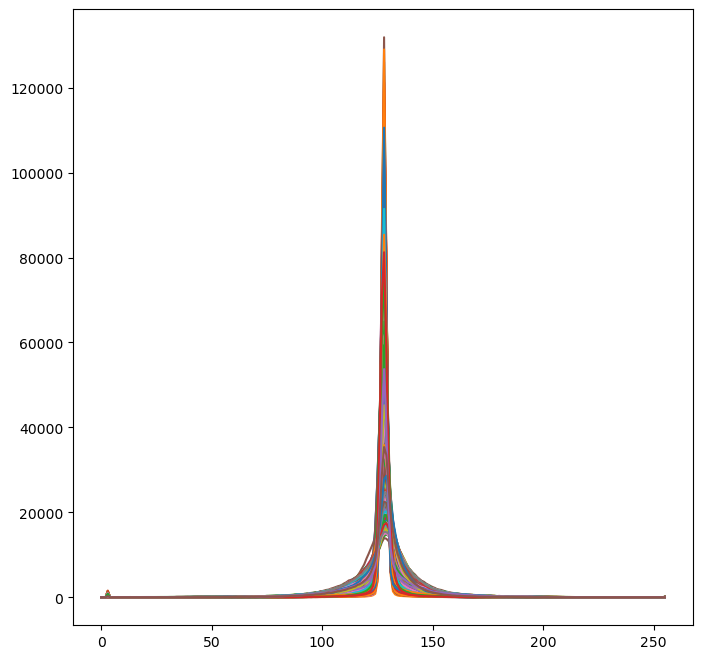

In [24]:
img_paths = Path(TRAIN_PATH).glob("*")
bar = tqdm(img_paths, total=df_train.id.unique().shape[0])     # should not be: total=len(list(img_paths))

plt.figure(figsize=(8,8))
for img_path in bar:
    img_bgr = cv2.imread(img_path.as_posix())    # BGR mode
    img_rgb = img_bgr[:, :, ::-1]                # RGB mode
    
    hist = cv2.calcHist([img_rgb], [0], None ,[256], [0,256])
    plt.plot(hist)
plt.show()

<br>

## Display Some Masks

### shsy5y

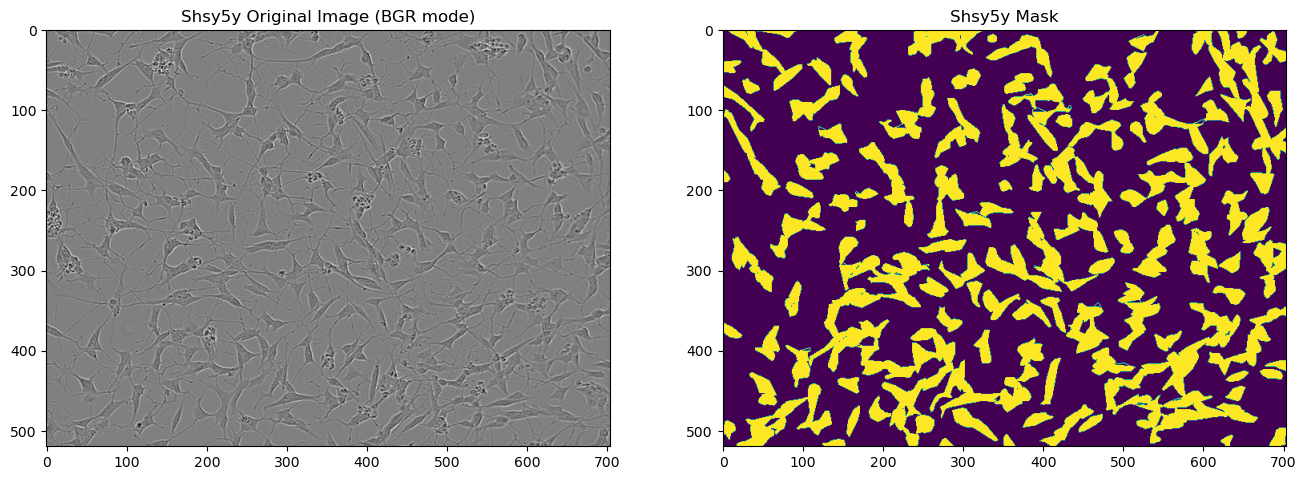

In [25]:
plt.figure(figsize=(16, 8))
img_id = "0030fd0e6378"
img = cv2.imread(TRAIN_PATH + img_id + ".png")         # BGR mode
# df_train[df_train.id == img_id].annotation.tolist()
ax1 = plt.subplot(121)
ax1.imshow(img)
ax1.set_title("Shsy5y Original Image (BGR mode)")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
ax2 = plt.subplot(122)
ax2.imshow(mask)
# plt.imshow(mask, cmap="gray")
# plt.imshow(mask, cmap = plt.cm.gray)
# plt.imshow(mask, cmap = plt.cm.gray_r)
ax2.set_title("Shsy5y Mask")

plt.show()

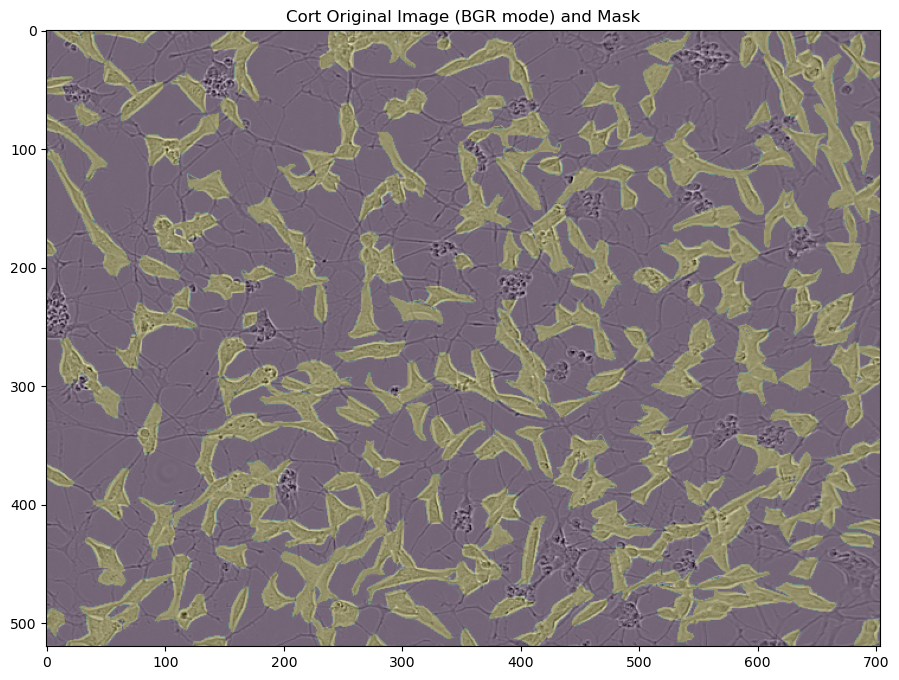

In [26]:
plt.figure(figsize=(16, 8))
img_id = "0030fd0e6378"
img = cv2.imread(TRAIN_PATH + img_id + ".png")          # BGR mode
plt.imshow(img)
plt.title("Cort Original Image (BGR mode) and Mask")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
plt.imshow(mask, alpha=0.2)

plt.show()

<br>

### astro

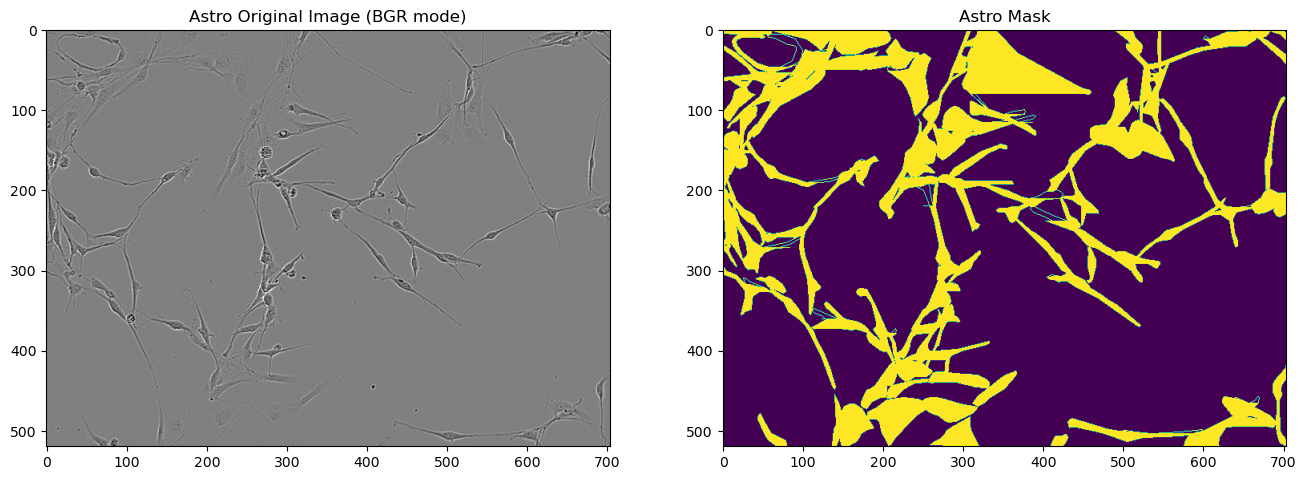

In [27]:
plt.figure(figsize=(16, 8))
img_id = "0140b3c8f445"
img = cv2.imread(TRAIN_PATH + img_id + ".png")         # BGR mode
# df_train[df_train.id == img_id].annotation.tolist()
ax1 = plt.subplot(121)
ax1.imshow(img)
ax1.set_title("Astro Original Image (BGR mode)")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
ax2 = plt.subplot(122)
ax2.imshow(mask)
# plt.imshow(mask, cmap="gray")
# plt.imshow(mask, cmap = plt.cm.gray)
# plt.imshow(mask, cmap = plt.cm.gray_r)
ax2.set_title("Astro Mask")

plt.show()

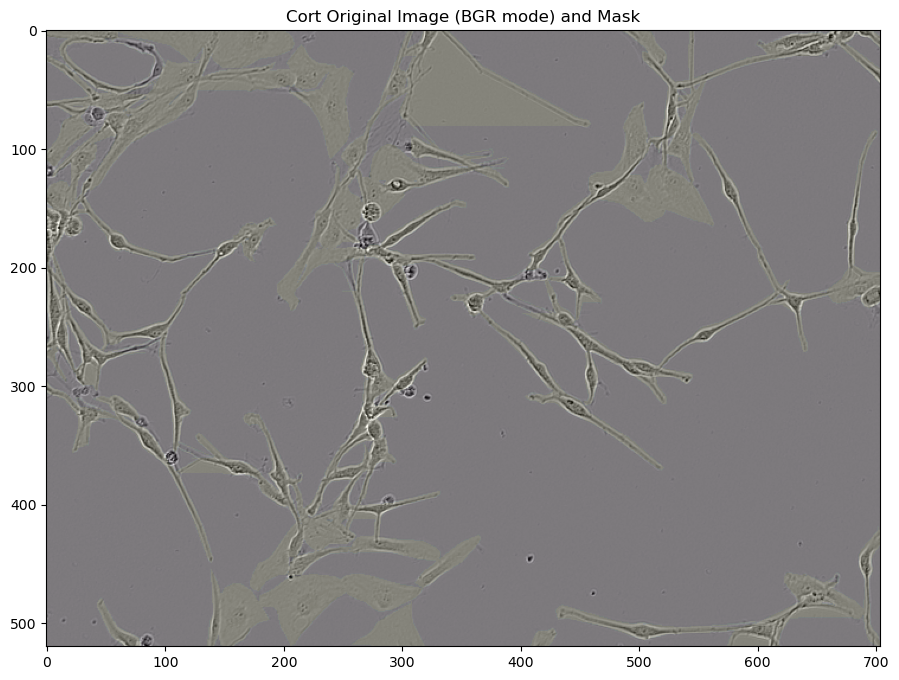

In [28]:
plt.figure(figsize=(16, 8))
img_id = "0140b3c8f445"
img = cv2.imread(TRAIN_PATH + img_id + ".png")          # BGR mode
plt.imshow(img)
plt.title("Cort Original Image (BGR mode) and Mask")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
plt.imshow(mask, alpha=0.05)

plt.show()

<br>

### cort

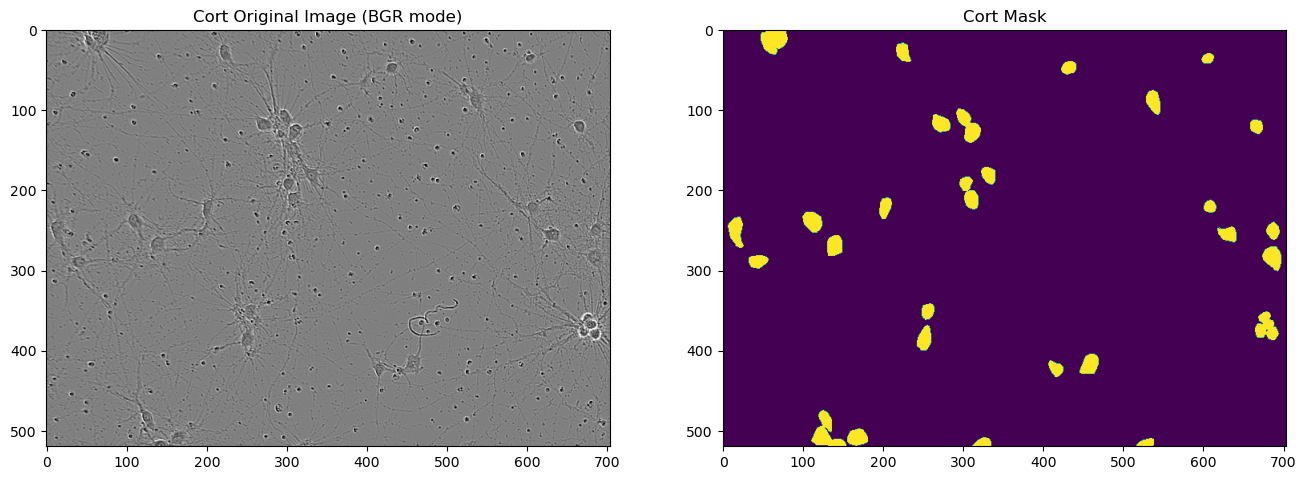

In [29]:
plt.figure(figsize=(16, 8))
img_id = "01ae5a43a2ab"
img = cv2.imread(TRAIN_PATH + img_id + ".png")         # BGR mode
# df_train[df_train.id == img_id].annotation.tolist()
ax1 = plt.subplot(121)
ax1.imshow(img)
ax1.set_title("Cort Original Image (BGR mode)")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
ax2 = plt.subplot(122)
ax2.imshow(mask)
# plt.imshow(mask, cmap="gray")
# plt.imshow(mask, cmap = plt.cm.gray)
# plt.imshow(mask, cmap = plt.cm.gray_r)
ax2.set_title("Cort Mask")

plt.show()

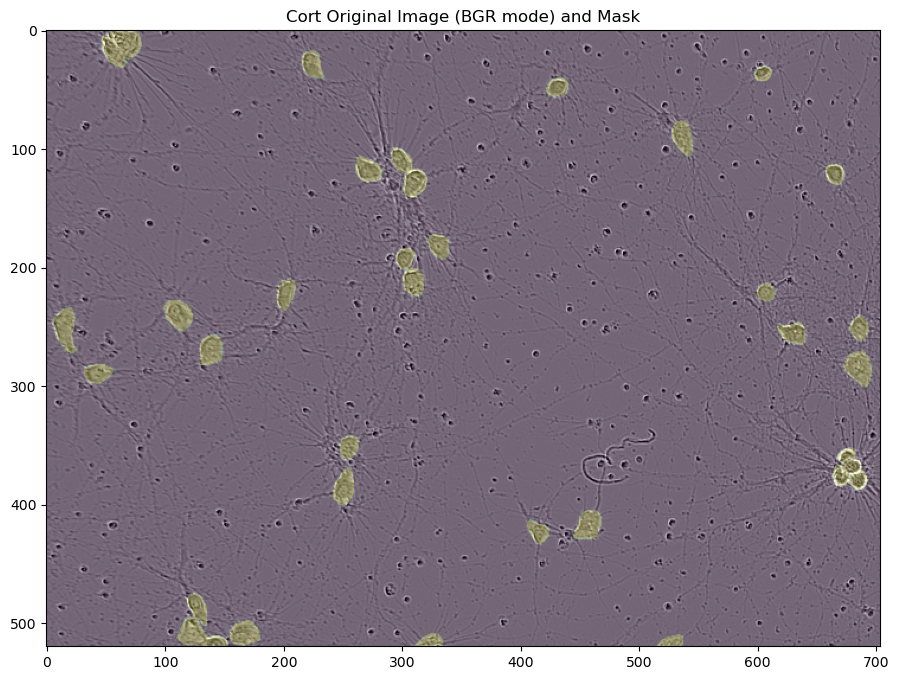

In [30]:
plt.figure(figsize=(16, 8))
img_id = "01ae5a43a2ab"
img = cv2.imread(TRAIN_PATH + img_id + ".png")          # BGR mode
plt.imshow(img)
plt.title("Cort Original Image (BGR mode) and Mask")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
plt.imshow(mask, alpha=0.2)

plt.show()

<br>

# Dataset and DataLoader

In [31]:
# 与前面定义的 df_instances 有些类似。

df_grouped = df_train.copy()
df_grouped['segment_count'] = 1    # train.csv 中 id 列是图片编号，每一行的 annotation 是该图片中一个细胞的 rle。
df_grouped = df_grouped.groupby(['id', 'width', 'height', 'cell_type']).count().reset_index()
df_grouped = df_grouped[['id', 'width', 'height', 'cell_type', 'segment_count']]
df_grouped

id  width  height cell_type  segment_count
0    0030fd0e6378    704     520    shsy5y            395
1    0140b3c8f445    704     520     astro            108
2    01ae5a43a2ab    704     520      cort             36
3    026b3c2c4b32    704     520      cort             42
4    029e5b3b89c7    704     520      cort             34
..            ...    ...     ...       ...            ...
601  fd98d82784a1    704     520     astro             11
602  fe33dfcf4ebd    704     520     astro             60
603  fe3e30f849f4    704     520    shsy5y            360
604  ffc2ead3e8cc    704     520     astro            134
605  ffdb3cc02eef    704     520      cort             77

[606 rows x 5 columns]

In [32]:
df_train.id.unique().shape

(606,)

<br>

## Define CellDataset()

In [33]:
class CellDataset(Dataset):
    def __init__(self, img_ids, df, train_path, transforms=None, train_val=True):
        super().__init__()
        self.df = df
        # self.img_ids = self.df.id.unique()    # 1D array
        self.img_ids = img_ids
        self.train_path = train_path
        self.transforms = transforms
        self.train_val = train_val
    
    
    def __len__(self):
        return self.img_ids.shape[0]
    
    
    def __getitem__(self, index):
        img_id = self.img_ids[index]
        
        # Read image
        img_bgr = cv2.imread(self.train_path + img_id + ".png")
        img_rgb = img_bgr[:, :, ::-1].astype(np.float32)
        img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)       # 3 channels -> 1 channel
        img /= 255.0                                          # normalization
        
        
        if self.train_val:  # For training and validation
            # Create mask
            rle_list = self.df[self.df.id == img_id]['annotation'].tolist()
            mask = build_image_mask(img, rle_list)
            
            # Transform image and mask
            if self.transforms:
                transformed = self.transforms(image=img, mask=mask)   # params: image, mask, bboxes, keypoints
                img, mask = transformed['image'], transformed['mask']
                
            return img, mask
        
        else: # For testing
            # Transform images
            if self.transforms:
                img =self.transforms(image=img)['image']
            
            return img, img_id

<br>

## Define train_val_dataloader()

In [34]:
def train_val_dataloader(df_grouped, df, train_idx, val_idx):
    train_ = df_grouped.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df_grouped.loc[val_idx,:].reset_index(drop=True)
    
    # Dataset
    train_dataset = CellDataset(train_["id"].to_numpy(), 
                                df, 
                                TRAIN_PATH, 
                                transforms=transforms())
    valid_dataset = CellDataset(valid_["id"].to_numpy(), 
                                df, 
                                TRAIN_PATH, 
                                transforms=transforms(train_only=False))
    
    # DataLoader
    train_loader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True
                             )
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=False
                             )
    
    return train_loader, valid_loader

<br>

## Define the UNet Model

In this notebook, we will implement the **U-Net** architecture using PyTorch, without relying on pre-existing implementations or models.

In [35]:
class DoubleConv(nn.Module):
    """DoubleConv is a basic building block of the encoder and decoder components. 
    Consists of two convolutional layers followed by a ReLU activation function.
    """
    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        
        self.double_conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(out_channels),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                         nn.BatchNorm2d(out_channels),
                                         nn.ReLU(inplace=True)
                                        )
        
    def forward(self, x):
        x = self.double_conv(x)

        return x

In [36]:
class Down(nn.Module):
    """Downscaling"""
    
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2),
                                          DoubleConv(in_channels, out_channels)
                                         )
        
    def forward(self, x):
        x = self.maxpool_conv(x)
        
        return x

In [37]:
class Up(nn.Module):
    """Upscaling.
    Performed using transposed convolution and concatenation of feature maps from the corresponding "Down" operation.
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)   # 这里为什么会有 3 个参数？？？
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    
    def forward(self, x1, x2):
        """x1 (batch_size, channels, height, width): low-level feature from expanding path
           x2 (batch_size, channels, height, width): high-level feature from contracting path
        """
        x1 = self.up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, 
                                    diffY // 2, diffY - diffY // 2]
                              )
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        
        return x

<br>

In [38]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        # self.in_conv = DoubleConv(in_channels, 64)   # 报错：NotImplementedError: 
        self.in_conv = (DoubleConv(in_channels, 64))   # 报错：NotImplementedError: 
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        
        self.down4 = Down(512,1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.out_conv = nn.Conv2d(64, n_classes, 1)
    
    
    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out_conv(x)
        x = torch.sigmoid(x)
        
        return x

<br>

# Training

As we did in the previous notebooks, we will perform cross-validation to evaluate the settings and determine the best combinations of architectures and hyperparameters.

To effectively track the model's performance, I recommend utilizing MLOps tools like <a href="https://mlflow.org/" style="text-decoration:none">MLFlow</a>.

Before running the following cell, please set configs <del>in the **Configurations** section</del>: `RUN_TRAINING = True` and `TRAIN_ALL = (as you want)`.

## Training and Validation

========================================== Cross-Validation Fold 1 ==========================================
Epoch 1 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5663      val_loss : 0.5521  (Exec time 1 min)

Epoch 2 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5471      val_loss : 0.5311  (Exec time 1 min)

Epoch 3 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5280      val_loss : 0.5127  (Exec time 1 min)

Epoch 4 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5096      val_loss : 0.4966  (Exec time 1 min)

Epoch 5 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4960      val_loss : 0.4823  (Exec time 1 min)

Epoch 6 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4818      val_loss : 0.4695  (Exec time 1 min)

Epoch 7 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4718      val_loss : 0.4580  (Exec time 1 min)

Epoch 8 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4626      val_loss : 0.4473  (Exec time 1 min)

========================================== Cross-Validation Fold 2 ==========================================
Epoch 1 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.6446      val_loss : 0.6334  (Exec time 1 min)

Epoch 2 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.6220      val_loss : 0.6094  (Exec time 1 min)

Epoch 3 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5972      val_loss : 0.5883  (Exec time 1 min)

Epoch 4 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5755      val_loss : 0.5695  (Exec time 1 min)

Epoch 5 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5568      val_loss : 0.5527  (Exec time 1 min)

Epoch 6 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5403      val_loss : 0.5373  (Exec time 1 min)

Epoch 7 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5237      val_loss : 0.5231  (Exec time 1 min)

Epoch 8 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5117      val_loss : 0.5101  (Exec time 1 min)

========================================== Cross-Validation Fold 3 ==========================================
Epoch 1 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.6989      val_loss : 0.6861  (Exec time 1 min)

Epoch 2 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.6709      val_loss : 0.6551  (Exec time 1 min)

Epoch 3 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.6411      val_loss : 0.6273  (Exec time 1 min)

Epoch 4 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.6155      val_loss : 0.6026  (Exec time 1 min)

Epoch 5 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5919      val_loss : 0.5805  (Exec time 1 min)

Epoch 6 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5708      val_loss : 0.5604  (Exec time 1 min)

Epoch 7 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5517      val_loss : 0.5423  (Exec time 1 min)

Epoch 8 Start Training:


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8 Start Validation:


  0%|          | 0/11 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5363      val_loss : 0.5257  (Exec time 1 min)



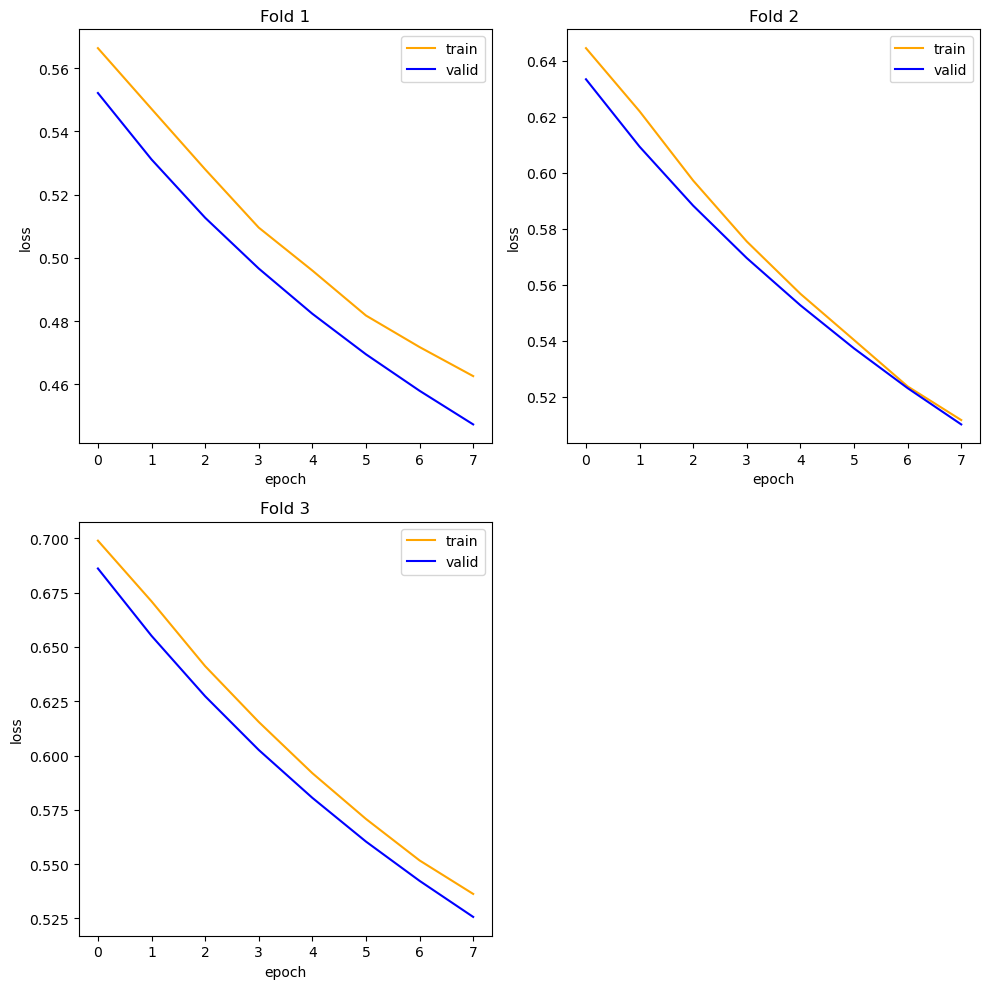

CPU times: user 27min 17s, sys: 20.5 s, total: 27min 37s
Wall time: 27min 39s


In [39]:
%%time

RUN_TRAINING = True
TRAIN_ALL = False

if RUN_TRAINING:
    if TRAIN_ALL:  # Train with all data
        folds = [['','']]
    else:          # Cross-validation
        folds = KFold(n_splits=FOLDS, shuffle=True, random_state=2023)\
                .split(np.arange(df_grouped.shape[0]), df_grouped['id'].to_numpy())
        
        train_loss_fold_list = []
        valid_loss_fold_list = []
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # Load Data   
        if TRAIN_ALL:
            train_dataset = CellDataset(df_grouped['id'].to_numpy(), df_train, DATA_DIR+'/train/', transforms=transform_train())
            train_loader = DataLoader(train_dataset, 
                                      batch_size=BATCH_SIZE, 
                                      num_workers=NUM_WORKERS, 
                                      shuffle=True
                                      )
        else:
            print("="*42 + f' Cross-Validation Fold {fold+1} ' + "="*42)   
            train_loader, valid_loader = train_val_dataloader(df_grouped, df_train, trn_idx, val_idx)
            
            valid_loss_epoch_list = []
        train_loss_epoch_list = []
        
        # Load model, loss function, and optimizing algorithm
        model = UNet().to(DEVICE)
        criterion = nn.BCELoss().to(DEVICE)
        optimizer = optim.SGD(model.parameters(), weight_decay=WEIGHT_DECAY, lr=LEARNING_RATE, momentum=MOMENTUM)
        
        # Start training
        best_loss = 10**5
        for epoch in range(EPOCHS):
            time_start = time.time()
            print(f'Epoch {epoch+1} Start Training:')
            model.train()
            train_loss = 0
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, (imgs, masks) in pbar:
            # for (imgs, masks) in train_loader:
                imgs = imgs.to(DEVICE).float()
                # imgs = torch.squeeze(imgs)
                masks = masks.to(DEVICE).float()
                masks = masks.view(imgs.shape[0], -1, 256, 256)
                
                optimizer.zero_grad()
                
                output = model(imgs)
                loss = criterion(output, masks)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            train_loss /= len(train_loader)           # Average train loss of this epoch

            # Validation
            if TRAIN_ALL == False:
                print(f'Epoch {epoch+1} Start Validation:')
                with torch.no_grad():
                    valid_loss = 0
                    preds = []
                    pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
                    for step, (imgs, masks) in pbar:
                    # for (imgs, masks) in valid_loader:
                        imgs = imgs.to(DEVICE).float()
                        # imgs = torch.squeeze(imgs)
                        masks = masks.to(DEVICE).float()
                        masks = masks.view(imgs.shape[0], -1, 256, 256)
                
                        val_output = model(imgs)
                        val_loss = criterion(val_output, masks)
                        
                        valid_loss += val_loss.item()
                    valid_loss /= len(valid_loader)   # Average validation loss of this epoch
                    
            # print results from this epoch
            exec_t = int((time.time() - time_start)/60)
            if TRAIN_ALL:
                print(">"*30 + f' train_loss: {train_loss:.4f}  (Exec time {exec_t} min)\n')

            else:
                print(">"*30 + f' train_loss: {train_loss:.4f}      val_loss : {valid_loss:.4f}  (Exec time {exec_t} min)\n')
                train_loss_epoch_list.append(train_loss)
                valid_loss_epoch_list.append(valid_loss)
        
        if TRAIN_ALL:
            print(">"*30 + f'Save model trained with all data:')
            os.makedirs(MODEL_DIR, exist_ok=True)
            torch.save(model.state_dict(), MODEL_DIR+'segmentation.pth')
            del model, optimizer, train_loader
        else:
            train_loss_fold_list.append(train_loss_epoch_list)
            valid_loss_fold_list.append(valid_loss_epoch_list)
            del model, optimizer, train_loader, valid_loader, train_loss_epoch_list, valid_loss_epoch_list
        gc.collect()
        torch.cuda.empty_cache()
    
    if TRAIN_ALL == False:
        plot_train_val_loss(train_loss_fold_list, valid_loss_fold_list)

else:
    print('RUN_TRAINING is False')

<br>

## Train All

In [40]:
%%time

RUN_TRAINING = True
TRAIN_ALL = True
EPOCHS = 30

if RUN_TRAINING:
    if TRAIN_ALL:  # Train with all data
        folds = [['','']]
    else:          # Cross-validation
        folds = KFold(n_splits=FOLDS, shuffle=True, random_state=2023)\
                .split(np.arange(df_grouped.shape[0]), df_grouped['id'].to_numpy())
        
        train_loss_fold_list = []
        valid_loss_fold_list = []
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # Load Data   
        if TRAIN_ALL:
            train_dataset = CellDataset(df_grouped['id'].to_numpy(), df_train, TRAIN_PATH, transforms=transforms())
            train_loader = DataLoader(train_dataset, 
                                      batch_size=BATCH_SIZE, 
                                      num_workers=NUM_WORKERS, 
                                      shuffle=True
                                      )
        else:
            print("="*42 + f' Cross-Validation Fold {fold+1} ' + "="*42)   
            train_loader, valid_loader = train_val_dataloader(df_grouped, df_train, trn_idx, val_idx)
            
            valid_loss_epoch_list = []
        
        train_loss_epoch_list = []
        
        # Load model, loss function, and optimizing algorithm
        model = UNet().to(DEVICE)
        criterion = nn.BCELoss().to(DEVICE)
        optimizer = optim.SGD(model.parameters(), weight_decay=WEIGHT_DECAY, lr=LEARNING_RATE, momentum=MOMENTUM)
        
        # Start training
        best_loss = 10**5
        for epoch in range(EPOCHS):
            time_start = time.time()
            print(f'Epoch {epoch+1} Start Training:')
            model.train()
            train_loss = 0
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, (imgs, masks) in pbar:
            # for (imgs, masks) in train_loader:
                imgs = imgs.to(DEVICE).float()
                # imgs = torch.squeeze(imgs)
                masks = masks.to(DEVICE).float()
                masks = masks.view(imgs.shape[0], -1, 256, 256)
                
                optimizer.zero_grad()
                
                output = model(imgs)
                loss = criterion(output, masks)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            train_loss /= len(train_loader)           # Average train loss of this epoch

            # Validation
            if TRAIN_ALL == False:
                print(f'Epoch {epoch+1} Start Validation:')
                with torch.no_grad():
                    valid_loss = 0
                    preds = []
                    pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
                    for step, (imgs, masks) in pbar:
                    # for (imgs, masks) in valid_loader:
                        imgs = imgs.to(DEVICE).float()
                        # imgs = torch.squeeze(imgs)
                        masks = masks.to(DEVICE).float()
                        masks = masks.view(imgs.shape[0], -1, 256, 256)
                
                        val_output = model(imgs)
                        val_loss = criterion(val_output, masks)
                        
                        valid_loss += val_loss.item()
                    valid_loss /= len(valid_loader)   # Average validation loss of this epoch
                    
            # print results from this epoch
            exec_t = int((time.time() - time_start)/60)
            if TRAIN_ALL:
                print(">"*30 + f' train_loss: {train_loss:.4f}  (Exec time {exec_t} min)\n')

            else:
                print(">"*30 + f' train_loss: {train_loss:.4f}      val_loss : {valid_loss:.4f}  (Exec time {exec_t} min)\n')
                train_loss_epoch_list.append(train_loss)
                valid_loss_epoch_list.append(valid_loss)
        
        if TRAIN_ALL:
            print(">"*30 + f'Save model trained with all data:')
            os.makedirs(MODEL_DIR + "save_models/", exist_ok=True)
            torch.save(model.state_dict(), MODEL_DIR + 'save_models/pytorch_unet.pth')
            del model, optimizer, train_loader
        else:
            train_loss_fold_list.append(train_loss_epoch_list)
            valid_loss_fold_list.append(valid_loss_epoch_list)
            del model, optimizer, train_loader, valid_loader, train_loss_epoch_list, valid_loss_epoch_list
        gc.collect()
        torch.cuda.empty_cache()
    
    if TRAIN_ALL == False:
        plot_train_val_loss(train_loss_fold_list, valid_loss_fold_list)

else:
    print('RUN_TRAINING is False')

Epoch 1 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.6887  (Exec time 1 min)

Epoch 2 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.6530  (Exec time 1 min)

Epoch 3 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.6183  (Exec time 1 min)

Epoch 4 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5876  (Exec time 1 min)

Epoch 5 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5606  (Exec time 1 min)

Epoch 6 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5370  (Exec time 1 min)

Epoch 7 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.5151  (Exec time 1 min)

Epoch 8 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4960  (Exec time 1 min)

Epoch 9 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4796  (Exec time 1 min)

Epoch 10 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4645  (Exec time 1 min)

Epoch 11 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4506  (Exec time 1 min)

Epoch 12 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4381  (Exec time 1 min)

Epoch 13 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4255  (Exec time 1 min)

Epoch 14 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4188  (Exec time 1 min)

Epoch 15 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.4076  (Exec time 1 min)

Epoch 16 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3990  (Exec time 1 min)

Epoch 17 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3925  (Exec time 1 min)

Epoch 18 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3852  (Exec time 1 min)

Epoch 19 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3809  (Exec time 1 min)

Epoch 20 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3725  (Exec time 1 min)

Epoch 21 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3681  (Exec time 1 min)

Epoch 22 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3626  (Exec time 1 min)

Epoch 23 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3599  (Exec time 1 min)

Epoch 24 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3530  (Exec time 1 min)

Epoch 25 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3499  (Exec time 1 min)

Epoch 26 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3455  (Exec time 1 min)

Epoch 27 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3433  (Exec time 1 min)

Epoch 28 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3375  (Exec time 1 min)

Epoch 29 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3363  (Exec time 1 min)

Epoch 30 Start Training:


  0%|          | 0/31 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> train_loss: 0.3338  (Exec time 1 min)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Save model trained with all data:
CPU times: user 36min 44s, sys: 23.9 s, total: 37min 8s
Wall time: 37min 8s


# Inference of Test Data


## Inference

In this task, the same Dataset, Image transformation, and model as we used for validation. So no need to define new functions.

Before running the following cells, please set `RUN_INFERENCE = True` <del>in the **Set Config** section</del>.

In [41]:
%%time

RUN_INFERENCE = True

if RUN_INFERENCE:
    files = os.listdir(TEST_PATH)
    image_ids = np.array([os.path.splitext(file)[0] for file in files])
    ids = []
    rle_test_preds = []
    original_size = (704, 520)   # (width, height)，需要传递给 cv2.resize() 第二个参数 dsize  的形式。

    # Load Data
    test_dataset = CellDataset(image_ids, 
                               df_train, 
                               TEST_PATH, 
                               transforms=transforms(train_only=False), 
                               train_val=False)

    # Data Loader
    test_loader = DataLoader(test_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False
                             )

    # Load model, loss function, and optimizing algorithm
    model = UNet().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_DIR + 'save_models/pytorch_unet.pth'))
       
    # Start Inference
    print("="*42 + f' Start Inference ' + "="*42)
    with torch.no_grad():
        test_preds = []
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (imgs, image_ids) in pbar:
            print("step: ", step)
            imgs = imgs.to(DEVICE).float()
            output = model(imgs)

            # Convert the output from PyTorch to np.array
            output = output.detach().cpu().numpy()
            
            # run length encoding
            for image_id, predicted_mask in zip(image_ids, output):
                predicted_mask = np.squeeze(predicted_mask)
                
                # resize
                predicted_mask = cv2.resize(predicted_mask, original_size)
                # 这里需要注意，cv2.resize() 第二个参数 dsize  的形式虽然是 (width, height) 的形式，此处为 (704, 520)。
                # 但是 cv2.resize() 的输出图像仍然是 (height, width) 的形式，即此处为 (520, 704)
                
                rle_mask = rle_encode(predicted_mask)
                ids.append(image_id)
                rle_test_preds.append(rle_mask)
    
    df_submission = pd.DataFrame({'id': ids, 
                                  'predicted': rle_test_preds})
    print(df_submission.head())

else:
    print('RUN_INFERENCE is False')

========================================== Start Inference ==========================================


  0%|          | 0/1 [00:00<?, ?it/s]

step:  0
             id                                          predicted
0  7ae19de7bc2a  6084 2 6620 1 6788 3 8187 3 8193 1 8207 1 8897...
1  d8bfd1dafdc4  1585 1 2289 1 2992 4 3004 1 3695 5 10737 1 150...
2  d48ec7815252  2322 1 8523 4 8643 3 9227 4 9347 3 9934 3 1005...
CPU times: user 862 ms, sys: 82 ms, total: 944 ms
Wall time: 981 ms


## Visualize Predicted Mask

In [42]:
predicted_mask_last = predicted_mask
image_id_last = image_id

print(type(predicted_mask_last))
print(predicted_mask_last.shape)
print("image id: ", image_id_last)

<class 'numpy.ndarray'>
(520, 704)
image id:  d48ec7815252


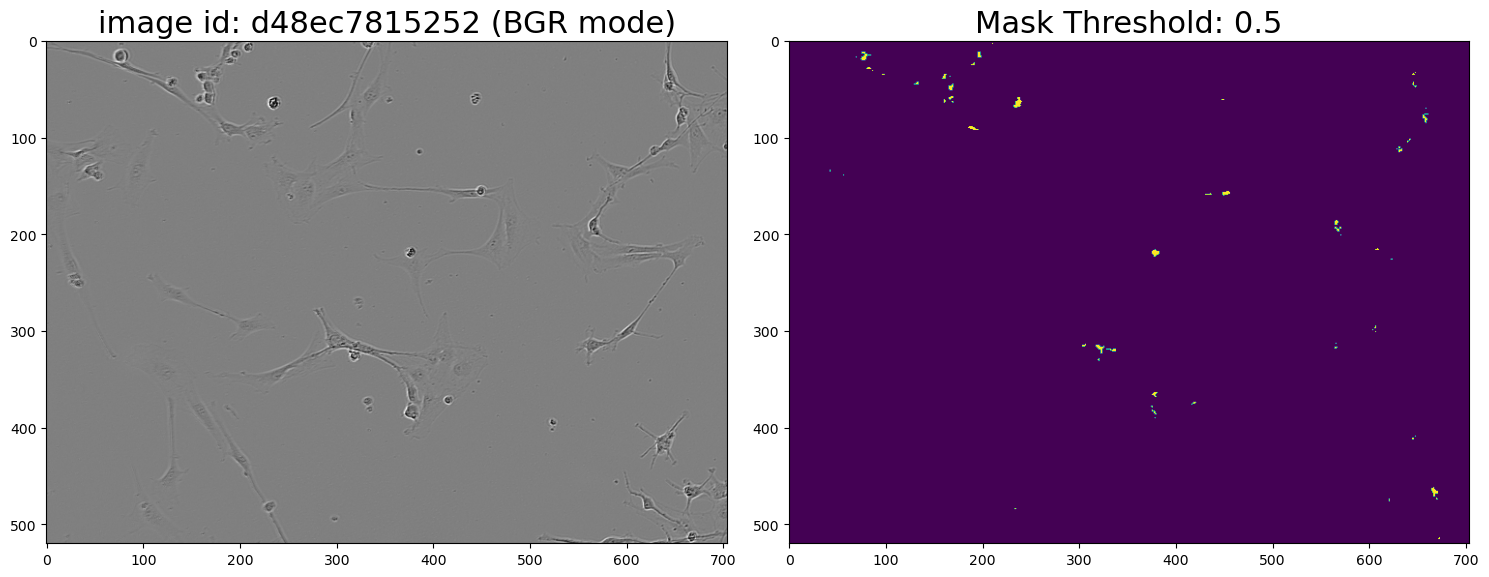

In [43]:
img = cv2.imread(TEST_PATH + image_id_last + ".png")   # BGR mode

plt.figure(figsize=(15, 20))
ax1 = plt.subplot(121)
ax1.imshow(img)
ax1.set_title(f"image id: {image_id_last} (BGR mode)",
              fontdict={"fontsize":22})

ax2 = plt.subplot(122)
ax2.imshow(predicted_mask_last > THRESHOLD_MASK)
ax2.set_title(f"Mask Threshold: {THRESHOLD_MASK}",
              fontdict={"fontsize":22})

plt.tight_layout()
plt.show()

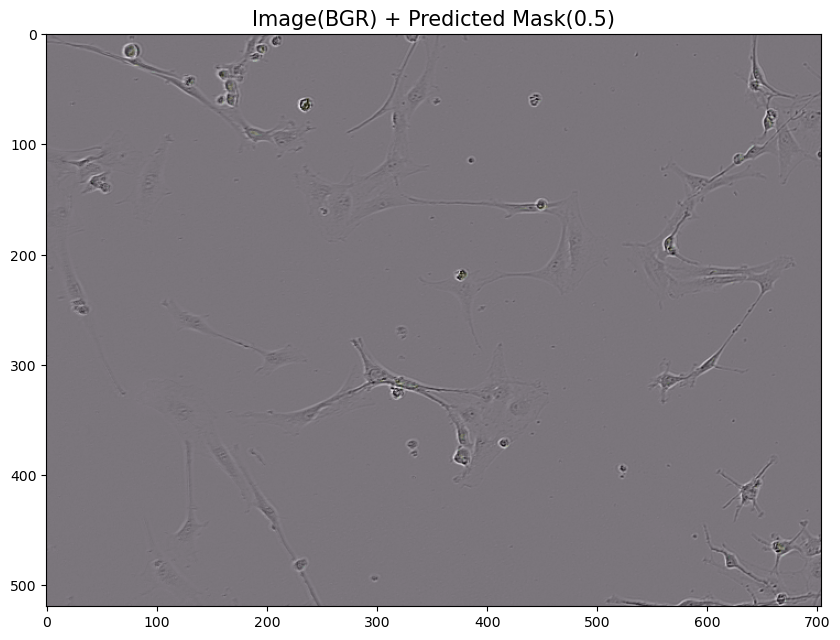

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(predicted_mask_last > THRESHOLD_MASK, alpha=0.08)
plt.title(f"Image(BGR) + Predicted Mask({THRESHOLD_MASK})", fontdict={"fontsize":15})
plt.show()

<br>

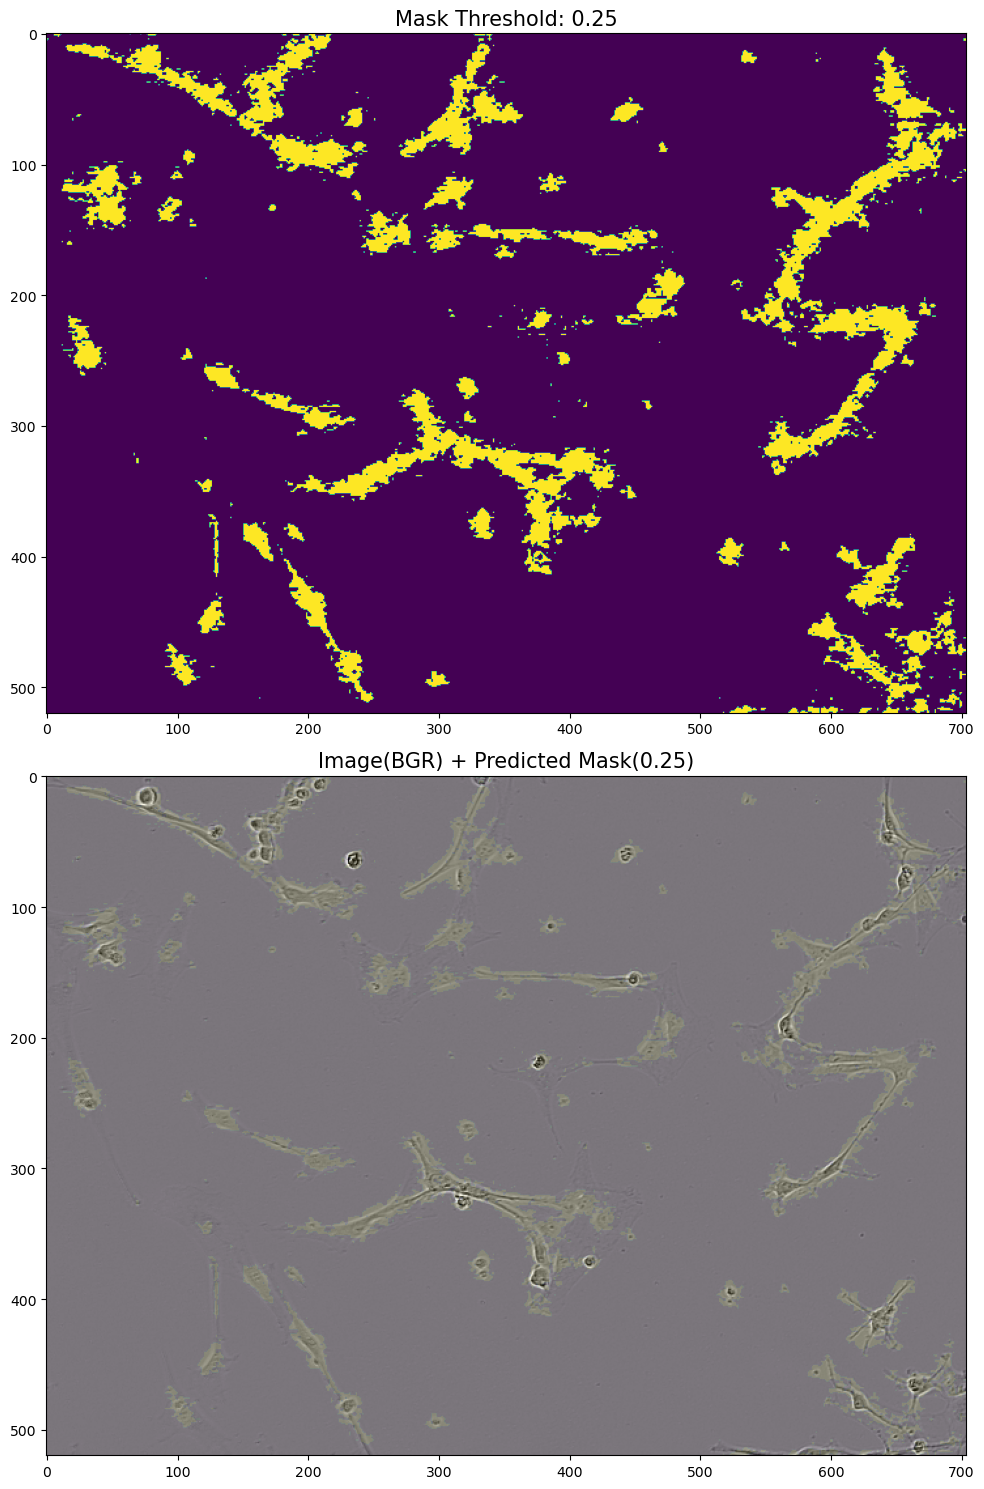

In [45]:
## Try another mask threshold value
threshold_mask = 0.25
plt.figure(figsize=(15, 15))
ax1 = plt.subplot(211)
ax1.imshow(predicted_mask_last > threshold_mask)
ax1.set_title(f"Mask Threshold: {threshold_mask}", fontdict={"fontsize":15})

ax2 = plt.subplot(212)
ax2.imshow(img)
ax2.imshow(predicted_mask_last > threshold_mask, alpha=0.08)
ax2.set_title(f"Image(BGR) + Predicted Mask({threshold_mask})", fontdict={"fontsize":15})
plt.tight_layout()
plt.show()

<br>

## Visualize Predicted RLE Mask

This confirms whether the output style is correct.

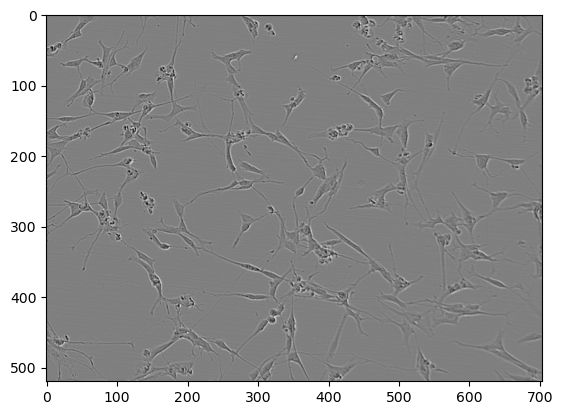

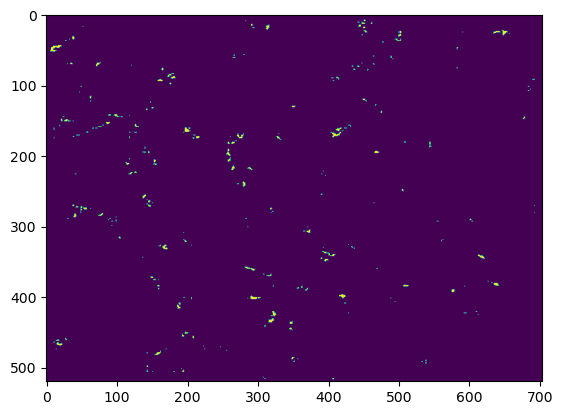

In [46]:
target = df_submission.iloc[0]
img = cv2.imread(f'{TEST_PATH}{target["id"]}.png')
rle_predicted = [target['predicted']]
mask = build_image_mask(img, rle_predicted)

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(mask)
plt.show()

<br>

# Submission

In [48]:
df_submission.to_csv(r'/kaggle/working/Unet_Pytorch_Mine.csv', index=False)

<br>

# To Improve the Model


Our segmentation model is now on the starting point. There are many techniques we can use to improve it.

Some potential approaches to consider include:

* **Preprocess input images**
    * Variety of augmentation such as flipping, rotating, and scaling the images.


* **Optimize the model**
    * A larger and more diverse training dataset
    * Experimenting with different architectures and hyperparameters
    * Choosing an appropriate Loss function, such as Dice Loss


* **Modify the model output**
    * Finding the best threshold
    * Using an ensemble of models
    * Postprocessing


By implementing these techniques, it's possible to build a highly accurate semantic segmentation model.

I trust that this notebook provided you with useful information for building an semantic segmentation model. Wishing you success in all your future modeling projects!